# Spatial Integration of ST and MSI

In this example we follow the steps for spatial multi-omics integration given in the original article.

In [1]:
import os
from os.path import exists

import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.base_types import Image, Annotation
from miit.spatial_data.spatial_omics.imzml import Imzml
from miit.spatial_data.spatial_omics.visium import Visium
from miit.registerers import GreedyFHistExt
from miit.registerers.other.msi_to_hist_meta_registerer import MSItoHistMetaRegisterer

In [2]:
if not exists('output_directory'):
    os.mkdir('output_directory')

## 1. Loading, initial alignment and preprocessing of data.

First, we load both source and target sections and register spatial omics data to the reference image.

In [3]:
reference_image_np = data=sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/reference_image.tif'))
reference_image = Image(data=reference_image_np)

tissue_mask_np = sitk.GetArrayViewFromImage(sitk.ReadImage('../data/hist/section1/tissue_mask.tif'))
tissue_mask = Annotation(data=tissue_mask_np, name='tissue_mask')

st_data = Visium.from_spcrng(directory='../data/visium/outs/')

target_section = Section(reference_image=reference_image,
                  annotations=[tissue_mask])
warped_st_data, registered_image = register_to_ref_image(target_section.reference_image.data, st_data.image.data, st_data)
target_section.so_data.append(warped_st_data)



source_section = Section()

msi_hist_image_path = '../data/hist/section3/reference_image.tif'
msi_hist_image = Image(data=sitk.GetArrayFromImage(sitk.ReadImage(msi_hist_image_path)))
source_section.reference_image = msi_hist_image

imzml_path = '../data/msi_neg/data.imzML'

imzml = Imzml.init_msi_data(imzml_path, name='negative_ion_mode')
pca_image = imzml.get_pca_img()
registerer = MSItoHistMetaRegisterer()
warped_imzml, _ = register_to_ref_image(source_section.reference_image.data, pca_image.data, imzml, registerer)

annotation_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section3/annotations.nii.gz'))
with open('../data/hist/section3/labels.txt') as f:
    labels = [x.strip() for x in f.readlines()]
annotations = Annotation(data=annotation_np, labels=labels, name='tissue_annotations')


source_section.so_data.append(warped_imzml)
source_section.annotations.append(annotations)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


## 2. Registration

Source section is registered to the target section using GreedyFHist.

In [4]:
registerer = GreedyFHistExt.init_registerer(path_to_greedy='greedy')

In [5]:
transformation = registerer.register_images(
    moving_img=source_section.reference_image.data,
    fixed_img=target_section.reference_image.data
)

In [6]:
warped_section = source_section.apply_transform(registerer, transformation)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Registered Visium Section')

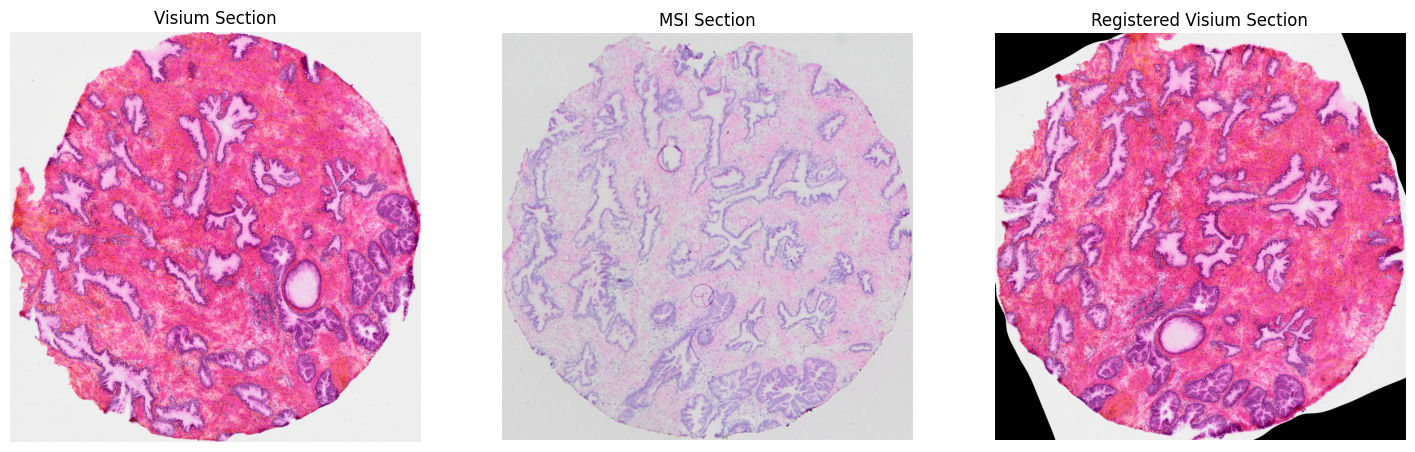

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(source_section.reference_image.data)
axs[0].set_title('Visium Section')
axs[1].imshow(target_section.reference_image.data)
axs[1].set_title('MSI Section')
axs[2].imshow(warped_section.reference_image.data)
axs[2].set_title('Registered Visium Section')

We can also show for the registration affects the reference matrix.

Text(0.5, 1.0, 'MSI Reference Matrix after Registration')

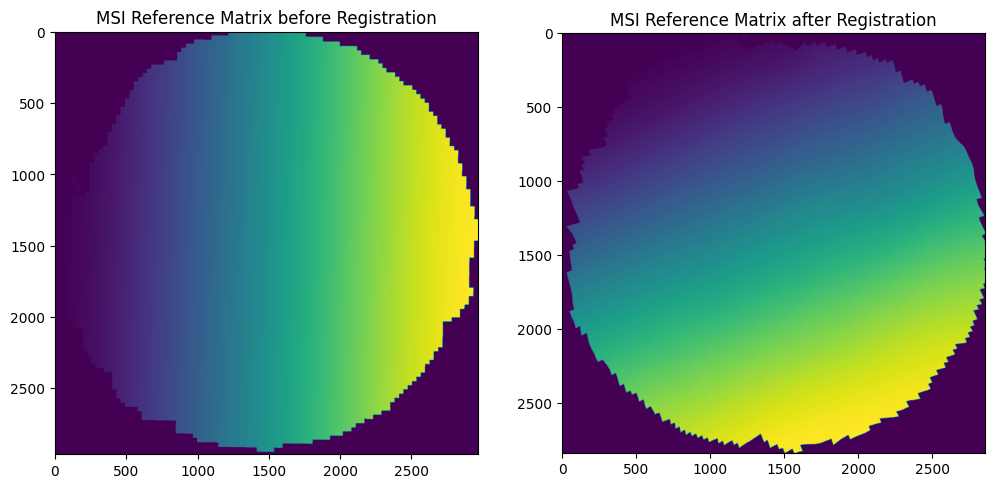

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
msi = source_section.so_data[0]
reg_msi = warped_section.so_data[0]
axs[0].imshow(msi.ref_mat.data)
axs[0].set_title('MSI Reference Matrix before Registration')
axs[1].imshow(reg_msi.ref_mat.data)
axs[1].set_title('MSI Reference Matrix after Registration')

We can also show that the registration worked on annotations.

(-0.5, 2855.5, 2833.5, -0.5)

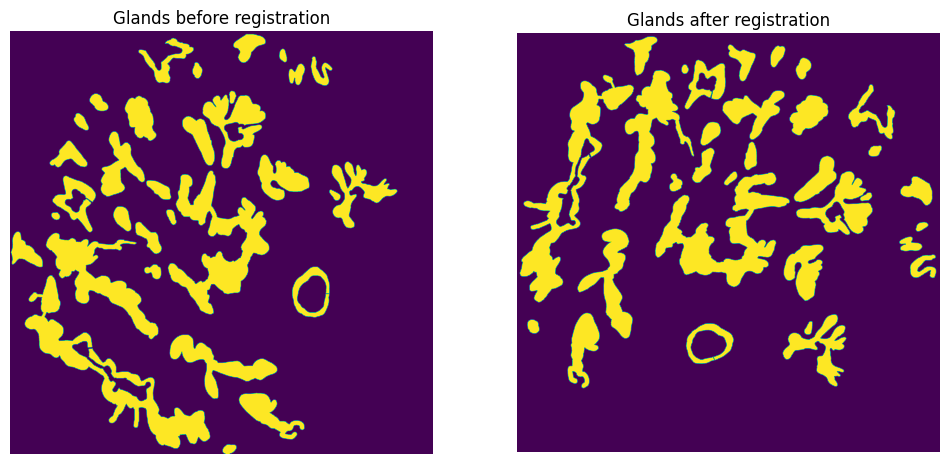

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
warped_annotation = warped_section.get_annotations_by_names('tissue_annotations')
axs[0].imshow(annotations.get_by_labels('Normal Glands'))
axs[0].set_title('Glands before registration')
axs[0].axis('off')
axs[1].imshow(warped_annotation.get_by_labels('Normal Glands'))
axs[1].set_title('Glands after registration')
axs[1].axis('off')

## 3. Transformation - MSI to ST

After all spatial data is aligned in the same coordinate system, we transform msi data to the spatial organization of spatial transcriptomics spots.

In [10]:
from miit.spatial_data.spatial_omics.imzml import (
    get_metabolite_intensities_targeted, 
    get_metabolite_intensities_from_full_spectrum,
    msi_default_accumulate_spot_weighted_mean, 
    msi_default_spot_accumulation_fun,
    
)
from miit.spatial_data.spatial_omics.visium import convert_table_to_mat
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts,
    transform_annotations_to_table
)
from pyimzml.ImzMLParser import ImzMLParser

Step 1: Find overlap between reference matrix. By default, 0 is assumed to denote the background in each reference matrix. `get_mappings` returns:

- `mapping`: a dictionary that maps for every unique reference id in the source reference matrix, the reference ids (including counts) in the target reference matrix. 
- `spots_background`: for each unique id in the source reference matrix the amount of overlap with background noise in the target reference matrix.
- `unique_target_reference`: A list of unique target references that have overlap with the source reference ids. 

In [11]:
st_data = target_section.so_data[0]
msi_data = warped_section.so_data[0] 
mappings, spots_background, unique_target_reference = get_mappings(st_data.ref_mat.data, msi_data.ref_mat.data, st_data.background, msi_data.background)

Step 2: We extract all intensities from the imzml file. We use the list unique references to only extract pixels which will be relevant for the subsequent merging. 
Row indices indicate the spectrum  and columns indices refer to the enumerated msi-pixels.

In [12]:
msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs)
metabolites_df.head()

,0,1,3,4,5,6,7,14,15,16,...,7340,7341,7342,7343,7344,7346,7347,7348,7349,7350
123.774,13.171091,31.194967,97.788445,104.587982,100.027939,7.365383,45.406445,57.978127,25.647928,117.277794,...,44.963398,63.855515,58.729740,28.710361,0.496102,41.196804,124.757797,100.801765,36.237965,83.897652
131.899,0.088008,0.797741,0.253439,0.019411,0.040094,1.178375,0.524792,0.092745,0.935219,0.859610,...,1.436559,3.764628,2.833724,1.519847,0.911508,0.668339,0.066503,0.734536,1.011046,0.097008
139.512,0.011477,0.154711,0.085851,0.054557,0.202255,0.220208,0.291796,0.006952,0.828949,1.668076,...,0.226554,2.225831,3.555549,0.210979,0.687597,0.325905,0.425435,0.440795,0.492106,0.794276
144.889,0.030401,0.009336,0.003128,0.034930,0.000462,0.005783,0.010794,0.112354,0.058369,0.009804,...,0.891517,0.064011,0.613088,0.512152,0.081209,0.081285,0.097135,0.176101,0.110951,0.473920
145.623,0.105758,0.042593,0.017247,0.024568,0.033717,0.069701,0.005077,0.012140,0.029446,0.199169,...,0.143483,0.314807,0.147011,0.337697,0.445186,0.025640,0.036806,0.095675,0.165381,0.074414


Step 3: We use the msi data and overlapping areas to accumulate the counts over the shared spatial transcriptomics spots.

In this example, we compute the weighted mean to accumulate spots using `msi_default_accumulate_spot_weighted_mean`. 

In [13]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,123.774,131.899,139.512,144.889,145.623,166.713,173.750,174.563,174.642,190.782,...,812.018,816.280,833.289,834.014,835.307,838.090,844.132,857.444,861.433,863.246
CGCGCCAAGCGATCAT-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CGGTGACCAGACAGCG-1,35.124088,0.178696,0.550021,0.120676,0.054231,0.765658,0.040875,1.685000,0.060979,53.443832,...,0.036848,4.087451e-02,0.066507,0.385949,0.073344,1.458273,0.073378,0.033549,0.054784,4.630861
AATCTTAATTGTTGGT-1,26.552689,0.144308,0.222567,0.140056,0.006588,0.130078,0.028851,1.010339,0.029072,26.357652,...,0.039433,4.756866e-02,0.018515,0.052173,0.020551,1.678048,0.051297,0.092197,0.088572,3.089694
AGGGCGTCCCATAGAC-1,0.148790,0.000131,0.000295,0.000123,0.000036,0.001556,0.000133,0.007555,0.000084,0.031597,...,0.000154,1.238077e-07,0.000134,0.000047,0.000102,0.004004,0.000018,0.000031,0.000085,0.001544
CGGCTCTTAAAAACGA-1,8.315999,0.005796,0.014343,0.003061,0.001557,0.041783,0.005984,0.316589,0.002177,1.109922,...,0.002451,1.811217e-03,0.005052,0.007816,0.002546,0.174013,0.003021,0.001112,0.005031,0.041683


### Alternatives to MSI accumulation

We provide some alternatives to accumulating MSI data for integration. First, we use the same function as before, but add a list of labels. For this, we load a table with a list of identified peaks from a previous publication.

In [14]:
peak_df = pd.read_csv('../data/msi_neg/IdentifiedPeaks.csv', sep=';')
peak_df.head()

,m/z,Interval Width (+/- Da),Color,Name
0,124.02,0.049608,#ff0000,Taurine
1,132.03,0.052812,#33a02c,Aspartate
2,140.02,0.056008,#6a33c2,PEA
3,145.07,0.058028,#ff7f00,Glutamine
4,146.06,0.058424,#ffd700,Glutamate


In [15]:
neg_labels = peak_df.Name.to_list()
msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs, neg_labels)
metabolites_df.head()

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


,0,1,3,4,5,6,7,14,15,16,...,7340,7341,7342,7343,7344,7346,7347,7348,7349,7350
Taurine,13.171091,31.194967,97.788445,104.587982,100.027939,7.365383,45.406445,57.978127,25.647928,117.277794,...,44.963398,63.855515,58.729740,28.710361,0.496102,41.196804,124.757797,100.801765,36.237965,83.897652
Aspartate,0.088008,0.797741,0.253439,0.019411,0.040094,1.178375,0.524792,0.092745,0.935219,0.859610,...,1.436559,3.764628,2.833724,1.519847,0.911508,0.668339,0.066503,0.734536,1.011046,0.097008
PEA,0.011477,0.154711,0.085851,0.054557,0.202255,0.220208,0.291796,0.006952,0.828949,1.668076,...,0.226554,2.225831,3.555549,0.210979,0.687597,0.325905,0.425435,0.440795,0.492106,0.794276
Glutamine,0.030401,0.009336,0.003128,0.034930,0.000462,0.005783,0.010794,0.112354,0.058369,0.009804,...,0.891517,0.064011,0.613088,0.512152,0.081209,0.081285,0.097135,0.176101,0.110951,0.473920
Glutamate,0.105758,0.042593,0.017247,0.024568,0.033717,0.069701,0.005077,0.012140,0.029446,0.199169,...,0.143483,0.314807,0.147011,0.337697,0.445186,0.025640,0.036806,0.095675,0.165381,0.074414


In [16]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,Taurine,Aspartate,PEA,Glutamine,Glutamate,Urate,NAA,Zinc,Ascorbate,Citrate,...,PS 118,PS 120,PI 121,PS 122,PI 123,PS 124,PS 125,PI 126,PI 128,PI 129
CGCGCCAAGCGATCAT-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CGGTGACCAGACAGCG-1,35.124088,0.178696,0.550021,0.120676,0.054231,0.765658,0.040875,1.685000,0.060979,53.443832,...,0.036848,4.087451e-02,0.066507,0.385949,0.073344,1.458273,0.073378,0.033549,0.054784,4.630861
AATCTTAATTGTTGGT-1,26.552689,0.144308,0.222567,0.140056,0.006588,0.130078,0.028851,1.010339,0.029072,26.357652,...,0.039433,4.756866e-02,0.018515,0.052173,0.020551,1.678048,0.051297,0.092197,0.088572,3.089694
AGGGCGTCCCATAGAC-1,0.148790,0.000131,0.000295,0.000123,0.000036,0.001556,0.000133,0.007555,0.000084,0.031597,...,0.000154,1.238077e-07,0.000134,0.000047,0.000102,0.004004,0.000018,0.000031,0.000085,0.001544
CGGCTCTTAAAAACGA-1,8.315999,0.005796,0.014343,0.003061,0.001557,0.041783,0.005984,0.316589,0.002177,1.109922,...,0.002451,1.811217e-03,0.005052,0.007816,0.002546,0.174013,0.003021,0.001112,0.005031,0.041683


We also provide an additional function, that converts single measurements from tables to their spatial representation in the target image space of st data. 
For this we need a dataframe with barcodes as indices and a `Visium` object.

Text(0.5, 1.0, 'Heatmap of aspartate distribution.')

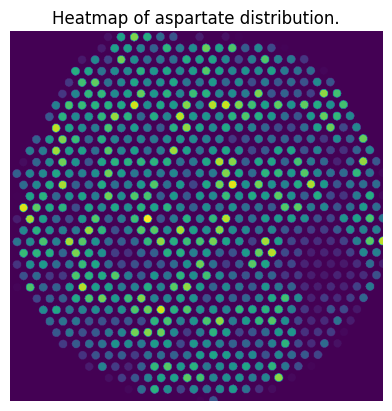

In [17]:
mat = convert_table_to_mat(integrated_df, st_data, 'Taurine')
plt.axis('off')
plt.imshow(mat)
plt.title('Heatmap of aspartate distribution.')

Another alternative to using the weighted mean to accumulate to spots, can be used with `msi_default_spot_accumulation_fun`. By default, this method accumulated using a number of standard statistical functions (i.e. max, mean median, min, std).

In [18]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_spot_accumulation_fun)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,max_ADP,mean_ADP,median_ADP,min_ADP,std_ADP,max_AMP,mean_AMP,median_AMP,min_AMP,std_AMP,...,median_Urate,min_Urate,std_Urate,max_Zinc,mean_Zinc,median_Zinc,min_Zinc,std_Zinc,n_bck_pixls,n_pixels
CGCGCCAAGCGATCAT-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1824,1824
CGGTGACCAGACAGCG-1,0.208861,0.116526,0.095946,0.034056,0.056026,0.076926,0.026365,0.017191,0.005271,0.016070,...,0.763615,0.033547,0.237136,2.554321,1.685000,1.770143,1.020038,0.385803,0,3152
AATCTTAATTGTTGGT-1,0.085152,0.028182,0.000000,0.000000,0.032463,0.040617,0.009822,0.000000,0.000000,0.010682,...,0.000000,0.000000,0.157860,2.352423,1.010339,0.000000,0.000000,1.069090,1619,3140
AGGGCGTCCCATAGAC-1,0.125694,0.000320,0.000000,0.000000,0.006333,0.003895,0.000010,0.000000,0.000000,0.000196,...,0.000000,0.000000,0.030804,2.969273,0.007555,0.000000,0.000000,0.149613,3136,3144
CGGCTCTTAAAAACGA-1,0.122876,0.003251,0.000000,0.000000,0.016407,0.095735,0.005437,0.000000,0.000000,0.020879,...,0.000000,0.000000,0.262370,4.399287,0.316589,0.000000,0.000000,1.102909,2877,3116


Finally, all previous examples used an imzML file with preselected metabolite intensities. We also have functionality for dealing with imzML files containing prefiltered spectra. Intensity values from full spectra can be extracted using the function `get_metabolite_intensities_from_full_spectrum`.

### 3. Transformation - Annotations to ST organization

Another example is, that we can transform annotations onto the ST organization.

In [19]:
integrated_annotation = transform_annotations_to_table(target_section.so_data[0], warped_annotation)

In [20]:
integrated_annotation

,Empty,Stroma,Normal Glands,ISUP1,ISUP2,ISUP3,ISUP4,ISUP5,ISUPY,ISUPX,Lymphocytes,Lymphocyte_enriched_stroma,PNI,PIN,Tissue,Vessel,Stone,Uncertain,Lumen
TTTGGTGGTGTTTAAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAATCATCTCATACAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTAAGGCAGTTTAAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGGTGATACAGTTGAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGGCCAACTACTTGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTCGGGGGGTATCGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGAATAAATGTACTAG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCCTAACGAGGCCTTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTGACAAACTAATGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can use `convert_table_to_mat` on annotations as well.

Text(0.5, 1.0, 'Stroma distribution over ST data.')

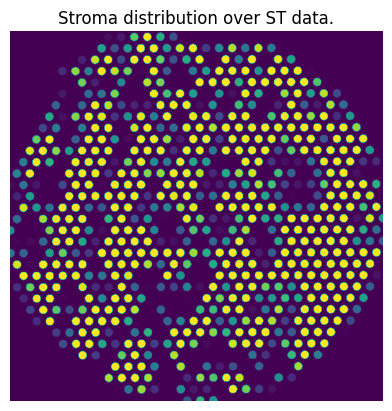

In [21]:
mat = convert_table_to_mat(integrated_annotation, st_data, 'Stroma')
plt.axis('off')
plt.imshow(mat)
plt.title('Stroma distribution over ST data.')

## 4. Export

In this example we simply export the data to the `csv` format. For an example on exporting to `imzml` format, see `03_integrate_msi_and_msi`.

In [22]:
integrated_df.to_csv('output_directory/integrated_msi.csv')

In [23]:
integrated_annotation.to_csv('output_directory/integrated_annotation.csv')